In [1]:
import polars as pl 
import polars.selectors as cs

In [2]:
new_features = []

## 01 滞后特征

取上一天的responder的变量的最后一个值(也就是最后一个time_id对应的值)作为新特征

In [3]:
train = pl.read_parquet(r'/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=*/part-0.parquet')

In [4]:
train = train.filter(pl.col('date_id')>1100)

In [5]:
target_col = "responder_6"  ##目标变量
lag_cols_original = ["date_id", "symbol_id"] + [f"responder_{idx}" for idx in range(9)]  ##初始responder变量
lag_cols_rename = { f"responder_{idx}" : f"responder_{idx}_lag_1" for idx in range(9)}   ##列名映射字典


In [6]:
##选择lag变量并重命名
lags = train.select(pl.col(lag_cols_original))
lags = lags.rename(lag_cols_rename)

In [7]:
lags = lags.with_columns(date_id = pl.col('date_id') + 1)  # 滞后一天
lags = lags.group_by(["date_id", "symbol_id"], maintain_order=True).last()  #选择上一天的最后一条数据
train = train.join(lags, on=["date_id", "symbol_id"],  how="left") ##将做好的新特征拼回训练数据


In [8]:
##将所有带lag的特征加入到新特征中
new_features.extend(train.select(cs.matches("lag")).columns)

In [9]:
new_features

['responder_0_lag_1',
 'responder_1_lag_1',
 'responder_2_lag_1',
 'responder_3_lag_1',
 'responder_4_lag_1',
 'responder_5_lag_1',
 'responder_6_lag_1',
 'responder_7_lag_1',
 'responder_8_lag_1']

## 02 整体统计特征

feature_09、feature_10、feature_11明显是分类变量，可能是股票的行业分类，可以根据其计算行业的整体统计特征

In [10]:
train['feature_09'].n_unique(),train['feature_10'].n_unique(),train['feature_11'].n_unique()

(22, 9, 29)

In [11]:
responder_6_stat = train.group_by(['feature_09','feature_10','feature_11']).agg(
    pl.mean('responder_6').alias('responder_6_mean'),  ##均值
    pl.median('responder_6').alias('responder_6_median'),  ##中位数
    pl.std('responder_6').alias('responder_6_std'),      ##标准差
    pl.col("responder_6").skew().alias('responder_6_skew'), ##偏度
    pl.col("responder_6").kurtosis().alias('responder_6_kurtosis'),  ##峰度

)
train =train.join(responder_6_stat,on=['feature_09','feature_10','feature_11'],how='left')

new_features.extend(responder_6_stat.select(cs.matches('responder_6')).columns)


In [12]:
new_features

['responder_0_lag_1',
 'responder_1_lag_1',
 'responder_2_lag_1',
 'responder_3_lag_1',
 'responder_4_lag_1',
 'responder_5_lag_1',
 'responder_6_lag_1',
 'responder_7_lag_1',
 'responder_8_lag_1',
 'responder_6_mean',
 'responder_6_median',
 'responder_6_std',
 'responder_6_skew',
 'responder_6_kurtosis']

## 03 滑动窗口特征

In [13]:
window_features = ['feature_75','feature_76','feature_77']
windows = [5,10,30]

In [14]:
train = train.sort(by=["date_id","symbol_id",'time_id'])
df_partition_by = train.partition_by(['date_id','symbol_id',],as_dict=True)  ##将train按date_id和symbol_id分块
df_rolloing = []
for k,df_ in df_partition_by.items() :
    for feature in window_features:
        for window in windows:
            df_ = df_.with_columns(pl.col(feature).rolling_mean(window,min_periods=window).alias(f'{feature}_ma_{window}'))
    df_rolloing.append(df_)
train = pl.concat(df_rolloing)

for feature in window_features:
    for window in windows:
        new_features.extend([f'{feature}_ma_{window}'])


In [15]:
new_features

['responder_0_lag_1',
 'responder_1_lag_1',
 'responder_2_lag_1',
 'responder_3_lag_1',
 'responder_4_lag_1',
 'responder_5_lag_1',
 'responder_6_lag_1',
 'responder_7_lag_1',
 'responder_8_lag_1',
 'responder_6_mean',
 'responder_6_median',
 'responder_6_std',
 'responder_6_skew',
 'responder_6_kurtosis',
 'feature_75_ma_5',
 'feature_75_ma_10',
 'feature_75_ma_30',
 'feature_76_ma_5',
 'feature_76_ma_10',
 'feature_76_ma_30',
 'feature_77_ma_5',
 'feature_77_ma_10',
 'feature_77_ma_30']

## 05 特征筛选

### 5.1 特征相关性

通过计算新特征与目标变量的相关性进行筛选

In [16]:
data = train.fill_null(0)
del train
for new_feature in new_features:
    corr = data[[new_feature,'responder_6']].to_pandas().corr().iloc[0,1]
    print(f'correlation between {new_feature} and responder_6',corr)

correlation between responder_0_lag_1 and responder_6 0.002780256605533235
correlation between responder_1_lag_1 and responder_6 0.002040959932697912
correlation between responder_2_lag_1 and responder_6 0.00028261056394034086
correlation between responder_3_lag_1 and responder_6 0.00298030686473714
correlation between responder_4_lag_1 and responder_6 0.0026497247286785043
correlation between responder_5_lag_1 and responder_6 0.0005542826537600756
correlation between responder_6_lag_1 and responder_6 0.001652711918923911
correlation between responder_7_lag_1 and responder_6 0.001753497749112329
correlation between responder_8_lag_1 and responder_6 0.002189935667905991
correlation between responder_6_mean and responder_6 0.00911362552529109
correlation between responder_6_median and responder_6 0.00478381506799733
correlation between responder_6_std and responder_6 0.0017835082177312346
correlation between responder_6_skew and responder_6 0.0014949638475838577
correlation between respo

### 特征重要性

In [17]:
##导入训练模型需要的库
import lightgbm as lgb
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

通过训练模型看新特征的特征重要性与模型交叉验证结果

In [18]:

##自定义损失函数
def weighted_R2_score(preds, data):
    y_true = data.get_label()
    weights = data.get_weight()
    valid_score =  1- r2_score(y_true, preds, sample_weight=weights)
    return 'valid_loss', valid_score,False


def TrainModel(train_data, valid_data, lgb_params):
    print("Training Model...")
    model = lgb.train(lgb_params,
                        train_data,
                        num_boost_round=3000,
                        valid_sets=[valid_data],
                        feval=weighted_R2_score,
                        callbacks=[
                        lgb.callback.early_stopping(stopping_rounds=100),
                        lgb.callback.log_evaluation(period=200)]
                        )

    valid_pred = model.predict(valid_data.get_data())
    valid_score = round(1-weighted_R2_score(valid_pred, valid_data)[1],4)
    print("Valid Score:", valid_score)
    return model,valid_score

lgb_params = {
    "objective": "regression",       # 回归任务
    "metric": "rmse",                 # 使用 RMSE 作为评估指标
    "num_leaves": 64,                # 控制树的复杂度
    "subsample": 0.7,                # 每棵树使用的数据比例
    "colsample_bytree": 0.8,         # 每棵树使用的特征比例
    "learning_rate": 0.03,           # 学习率
    "n_estimators": 1500,            # 最大迭代次数
    "min_child_samples": 500,         # 最小叶子样本数
    "max_depth": 10,                 # 最大深度
    "reg_alpha": 0.001,               # L1 正则化
    "reg_lambda": 0.15,               # L2 正则化
    "bagging_freq": 5,               # 每多少次迭代进行一次 bagging
    "verbosity": 0,                   # 控制输出的详细程度
    "device": "gpu",                 # 使用 GPU 加速
}

In [19]:
feature_names = new_features

train = data.filter(pl.col('date_id')<1650)
valid = data.filter(pl.col('date_id')>=1650)

x_train = train[feature_names].to_pandas()
y_train = train["responder_6"].to_pandas()
x_valid = valid[feature_names].to_pandas()
y_valid = valid["responder_6"].to_pandas()

w_train = train['weight'].to_pandas()
w_valid = valid['weight'].to_pandas()

del train,valid

train_data = lgb.Dataset(x_train, label=y_train, free_raw_data=False).construct()
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data, free_raw_data=False).construct()


train_data.set_weight(w_train)
valid_data.set_weight(w_valid)

del x_train,x_valid,y_train,y_valid



In [20]:
model,valid_score = TrainModel(train_data,valid_data,lgb_params)

Training Model...


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 0.750558	valid_0's valid_loss: 0.999764
Valid Score: 0.0002


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

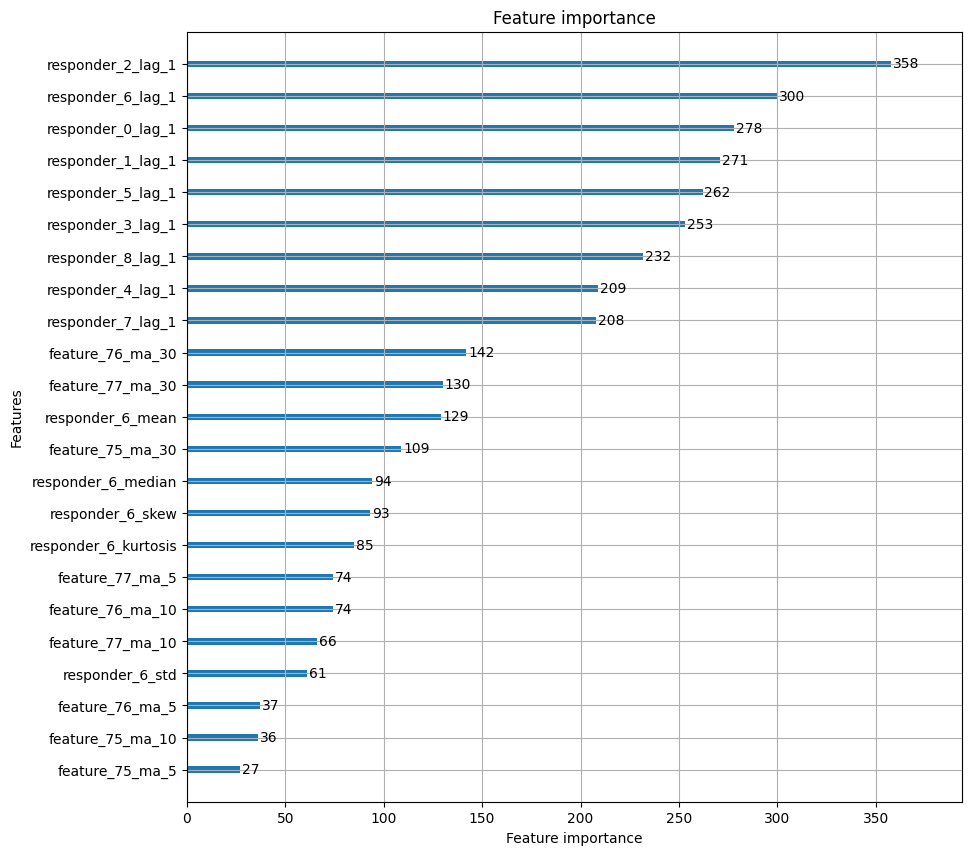

In [22]:
lgb.plot_importance(model,figsize=(10,10))